# Heart Disease Risk Prediction: Logistic Regression

## SetUp

In [9]:
%pip install numpy pandas matplotlib scikit-learn

  Using cached scikit_learn-1.8.0-cp314-cp314-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.17.0-cp314-cp314-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp314-cp314-win_amd64.whl (8.1 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached scipy-1.17.0-cp314-cp314-win_amd64.whl (37.1 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------------------------------------- 0/4 [threadpoolctl]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


np.set_printoptions(precision=4, suppress=True)

## Dataset Definition


In [11]:
df = pd.read_csv("data/Heart_Disease_Prediction.csv")

# Convert categorical target variable to numerical
df["Heart Disease"] = df["Heart Disease"].map({ 
    "Absence": 0,
    "Presence": 1
})

df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


## EDA: Exploratory Data Analysis

In [12]:
print("DATASET SHAPE AND INFO")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nBasic Statistics:\n{df.describe().T}")

DATASET SHAPE AND INFO
Shape: (270, 14)

Data Types:
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease                int64
dtype: object

Missing Values:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Basic 

In [13]:

print("MISSING VALUES AND OUTLIERS DETECTION")


# Detect missing values
missing_count = df.isnull().sum().sum()
print(f"Total missing values: {missing_count}")

# Detect outliers using IQR (Interquartile Range)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns: {numerical_cols}")

outliers_summary = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_summary[col] = len(outliers)
    
    if len(outliers) > 0:
        print(f"\n{col}:")
        print(f"  IQR: {IQR:.2f}, Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"  Outliers found: {len(outliers)} ({100*len(outliers)/len(df):.2f}%)")

print(f"\nTotal outliers by column: {outliers_summary}")

MISSING VALUES AND OUTLIERS DETECTION
Total missing values: 0

Numerical columns: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']

Chest pain type:
  IQR: 1.00, Bounds: [1.50, 5.50]
  Outliers found: 20 (7.41%)

BP:
  IQR: 20.00, Bounds: [90.00, 170.00]
  Outliers found: 9 (3.33%)

Cholesterol:
  IQR: 67.00, Bounds: [112.50, 380.50]
  Outliers found: 5 (1.85%)

FBS over 120:
  IQR: 0.00, Bounds: [0.00, 0.00]
  Outliers found: 40 (14.81%)

Max HR:
  IQR: 33.00, Bounds: [83.50, 215.50]
  Outliers found: 1 (0.37%)

ST depression:
  IQR: 1.60, Bounds: [-2.40, 4.00]
  Outliers found: 4 (1.48%)

Number of vessels fluro:
  IQR: 1.00, Bounds: [-1.50, 2.50]
  Outliers found: 19 (7.04%)

Total outliers by column: {'Age': 0, 'Sex': 0, 'Chest pain type': 20, 'BP': 9, 'Cholesterol': 5, 'FBS over 120': 40, 'EKG results': 0, 'Max HR': 1, 'Exercise 

CLASS DISTRIBUTION

Class distribution:
Heart Disease
0    150
1    120
Name: count, dtype: int64

Class proportions:
Heart Disease
0    0.555556
1    0.444444
Name: proportion, dtype: float64


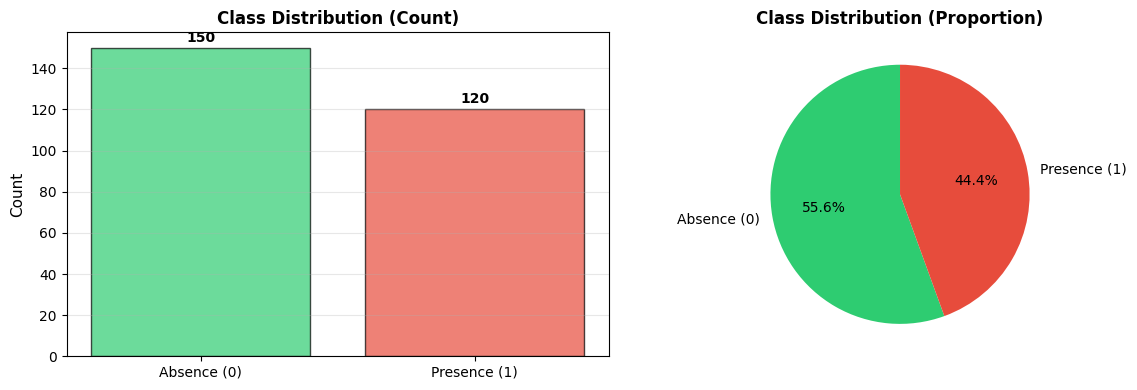

In [14]:

print("CLASS DISTRIBUTION")

target_col = "Heart Disease"
class_counts = df[target_col].value_counts().sort_index()
print(f"\nClass distribution:\n{class_counts}")
print(f"\nClass proportions:\n{df[target_col].value_counts(normalize=True).sort_index()}")

# View class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Chart 1: Class count
class_labels = ["Absence (0)", "Presence (1)"]
colors = ["#2ecc71", "#e74c3c"]
axes[0].bar(class_labels, class_counts.values, color=colors, alpha=0.7, edgecolor="black")
axes[0].set_ylabel("Count", fontsize=11)
axes[0].set_title("Class Distribution (Count)", fontsize=12, fontweight="bold")
axes[0].grid(axis="y", alpha=0.3)

# Add values on bars
for i, (label, count) in enumerate(zip(class_labels, class_counts.values)):
    axes[0].text(i, count + 3, str(count), ha="center", fontweight="bold")

# Chart 2: Class proportion (Pie chart)
axes[1].pie(class_counts.values, labels=class_labels, autopct="%1.1f%%", 
            colors=colors, startangle=90, textprops={"fontsize": 10})
axes[1].set_title("Class Distribution (Proportion)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


FEATURE DISTRIBUTIONS BY CLASS


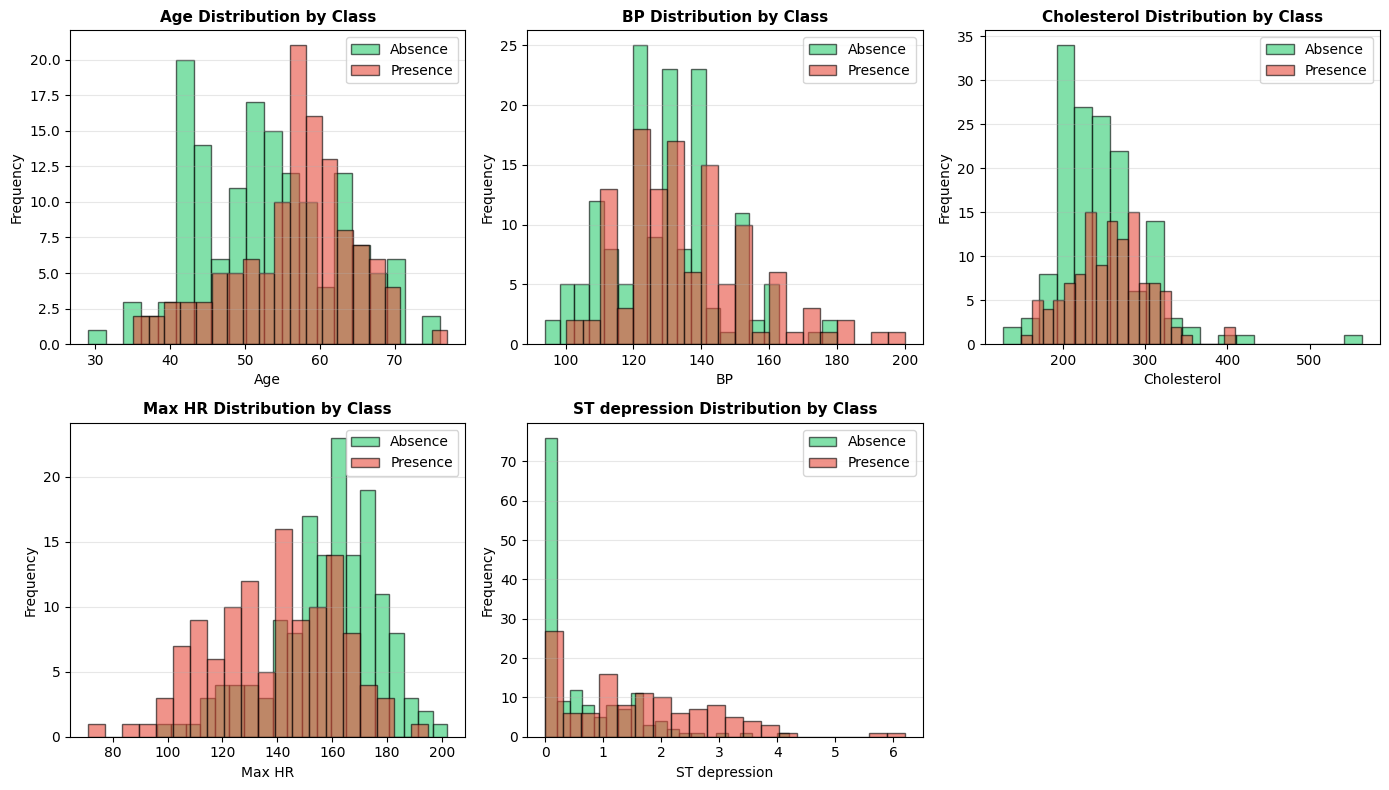

In [15]:
    
print("FEATURE DISTRIBUTIONS BY CLASS")

# Select important numerical features
key_features = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]
existing_features = [f for f in key_features if f in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, feature in enumerate(existing_features):
    ax = axes[idx]
    
    # Histograms separated by class
    absence = df[df[target_col] == 0][feature]
    presence = df[df[target_col] == 1][feature]
    
    ax.hist(absence, bins=20, alpha=0.6, label="Absence", color="#2ecc71", edgecolor="black")
    ax.hist(presence, bins=20, alpha=0.6, label="Presence", color="#e74c3c", edgecolor="black")
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"{feature} Distribution by Class", fontsize=11, fontweight="bold")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

# Hide the last subplot if not used
axes[-1].axis("off")

plt.tight_layout()
plt.show()


CORRELATION MATRIX


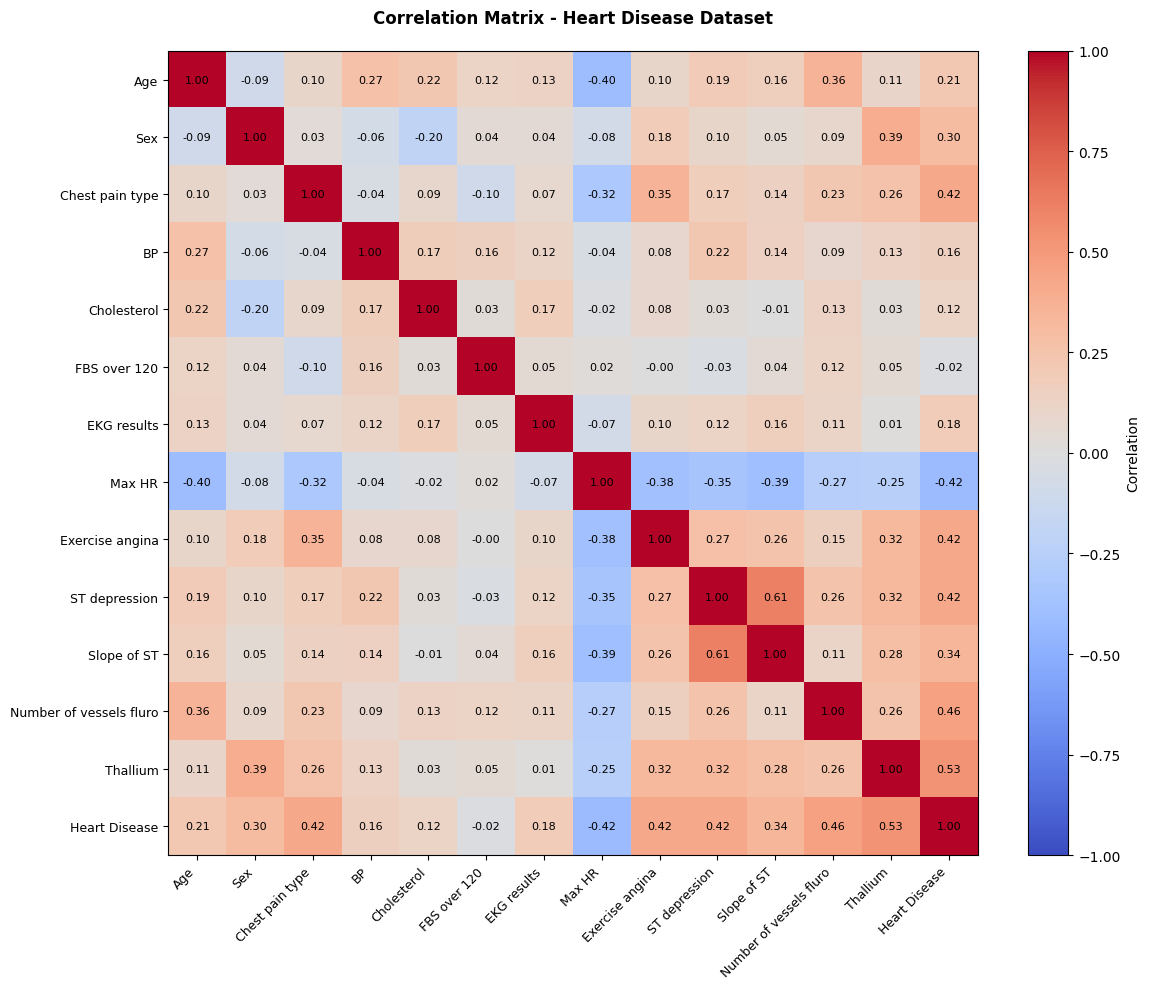

In [16]:
print("CORRELATION MATRIX")


# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)

# Labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(correlation_matrix.columns, fontsize=9)

# Add values in cells
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                      ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=ax, label="Correlation")
ax.set_title("Correlation Matrix - Heart Disease Dataset", fontsize=12, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()



## DataSet Preparation

In [17]:

# Select features for the model
selected_features = ['Age', 'Cholesterol', 'BP', 'Max HR', 'ST depression', 'Number of vessels fluro']
X = df[selected_features]
y = df[target_col]

# 70/30 stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")
print(f"\nClass distribution in training set:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"\nClass distribution in test set:\n{pd.Series(y_test).value_counts().sort_index()}")

Training set size: (189, 6)
Test set size: (81, 6)

Class distribution in training set:
Heart Disease
0    105
1     84
Name: count, dtype: int64

Class distribution in test set:
Heart Disease
0    45
1    36
Name: count, dtype: int64
